# Solve 1D advection diffusion problem

$$
\frac{\partial c}{\partial t} + w_s \frac{\partial c}{\partial z} - \frac{\partial}{\partial z}\left( F\right) =0
$$

where

$$
F=K_v \frac{\partial c}{\partial z}
$$

with boundary conditions

$$
F = f(t),\ z =0
$$

$$
F = 0,\ z=H
$$

In [ ]:
# Gotta find my FFTW_PATH
!export FFTW_PATH=/path/to/your/fftw_prefix 

In [4]:
!sudo pip install dedalus

[sudo] password for suntans: 


In [4]:
import time
import numpy as np
import dedalus.public as de
from dedalus.tools  import post

from dedalus.extras.plot_tools import quad_mesh, pad_limits


import logging
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

In [22]:
%matplotlib notebook



In [79]:
# Constants

H = 5. # Depth

nz = 64

K_0 = 1e-1 # Diffusivity - had to boost this to actually get the sediment into the water column
ws = 1e-3 # settling velocity

E = -1e-3 # constant erosion rate [c/s]
E = -1e-2 # constant erosion rate [c/s]

uniform_diffusion = True

In [80]:
# CReate the domain

z = de.Chebyshev('z',nz,interval=[0.,H])
domain = de.Domain([z],grid_dtype='float')


In [81]:
# Create the problem
problem = de.IVP(domain, variables=['c','F'])
problem.parameters['ws'] = ws
problem.parameters['E'] = E

if uniform_diffusion:
    problem.parameters['K'] = K_0
else:
    # Add vertically varying diffusion
    ncc = domain.new_field(name = 'K')
    ncc['g'] = (H-z)*K_0
    problem.parameters['K'] = ncc

problem.add_equation('dt(c) + ws * dz(c) - dz(F) = 0')
problem.add_equation('F - K * dz(c) = 0')

# Add the time varying boundary conditions
problem.add_bc('left(F) = E*abs(sin(t))')
problem.add_bc('right(F) = 0')

In [82]:
solver = problem.build_solver(de.timesteppers.RK443)

solver.stop_sim_time = 6*np.pi
solver.stop_wall_time = 1000.
solver.stop_iteration = np.inf
dt = 0.01

# Store data for final plot
# Initial conditions
z = domain.grid(0)
c = solver.state['c']

c.set_scales(1, keep_data=True)
c_list = [np.copy(c['g'])]
t_list = [solver.sim_time]

start_time = time.time()
while solver.ok:
    solver.step(dt)
    if solver.iteration % 20 == 0:
        logger.info("Time step {}".format(solver.iteration))
        c.set_scales(1, keep_data=True)
        c_list.append(np.copy(c['g']))
        t_list.append(solver.sim_time)
end_time = time.time()

# Print statistics
logger.info('Total time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)
logger.info('Average timestep: %f' %(solver.sim_time/solver.iteration))

2019-11-06 12:14:21,146 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+01/s
2019-11-06 12:14:21,269 __main__ 0/1 INFO :: Time step 20
2019-11-06 12:14:21,378 __main__ 0/1 INFO :: Time step 40
2019-11-06 12:14:21,461 __main__ 0/1 INFO :: Time step 60
2019-11-06 12:14:21,557 __main__ 0/1 INFO :: Time step 80
2019-11-06 12:14:21,647 __main__ 0/1 INFO :: Time step 100
2019-11-06 12:14:21,750 __main__ 0/1 INFO :: Time step 120
2019-11-06 12:14:21,846 __main__ 0/1 INFO :: Time step 140
2019-11-06 12:14:21,960 __main__ 0/1 INFO :: Time step 160
2019-11-06 12:14:22,082 __main__ 0/1 INFO :: Time step 180
2019-11-06 12:14:22,234 __main__ 0/1 INFO :: Time step 200
2019-11-06 12:14:22,397 __main__ 0/1 INFO :: Time step 220
2019-11-06 12:14:22,528 __main__ 0/1 INFO :: Time step 240
2019-11-06 12:14:22,659 __main__ 0/1 INFO :: Time step 260
2019-11-06 12:14:22,799 __main__ 0/1 INFO :: Time step 280
2019-11-06 12:14:22,944 __main__ 0/1 INFO :: Time step 3

In [83]:
c_array = np.array(c_list)
t_array = np.array(t_list)
zmesh, tmesh = quad_mesh(x=z, y=t_array)

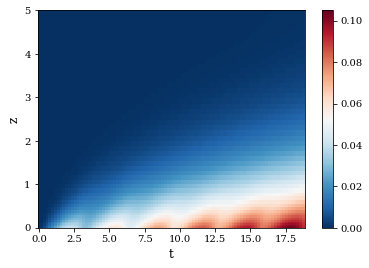

In [84]:
plt.figure()
plt.pcolormesh(tmesh.T, zmesh.T, c_array.T, cmap='RdBu_r')
plt.axis(pad_limits(tmesh, zmesh))
plt.colorbar()
plt.ylabel('z')
plt.xlabel('t')

plt.show()

In [48]:
c_array.shape, z.shape, len(t_list)

((63, 64), (64,), 63)

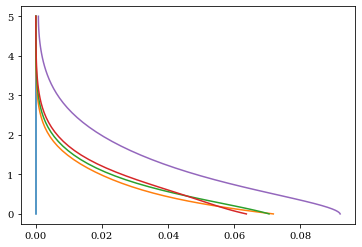

In [68]:
plt.figure()
plt.plot(c_array[0,:],z)
plt.plot(c_array[40,:],z)
plt.plot(c_array[45,:],z)
plt.plot(c_array[50,:],z)
plt.plot(c_array[-1,:],z)